In [20]:
import re
import time
import requests
import pandas as pd
import numpy as np
from scrapy.http import TextResponse
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import qqplot
import statsmodels.stats as sms #for BP test
from statsmodels.formula.api import ols #for linear regression
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import shapiro
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [3]:
def scraper(url,css):
    page=requests.get(url)
    response=TextResponse(url=page.url, body=page.text,encoding="utf-8" )
    elements=response.css(css).extract()
    return elements

In [4]:
def df_scraper(url):
    response = requests.get(url)
    response = TextResponse(url = response.url, body = response.text, encoding = "utf-8")
    df = pd.read_html(url)[0].transpose()
    df.columns = df.iloc[0,:]
    df = df.iloc[1:,:]
    df['url'] = url
    return df

In [5]:
all_urls = []
i = 1
css = "h3[class='title']>a::attr(href)"

In [6]:
while True:
    url = "https://www.celebritynetworth.com/category/richest-celebrities/page/{}/".format(i)
    current_url = scraper(url, css)
    if len(current_url)> 0:
        all_urls.extend(current_url)
        time.sleep(2)
        i=i+1
    else:
        break

In [7]:
urls = list(set(all_urls))

In [8]:
dfs = []

In [10]:
for url in urls:
    try:
        dfs.append(df_scraper(url))
    except: 
        pass
    time.sleep(2)

In [11]:
celebrity_df = pd.concat(dfs, sort=False)

In [13]:
celebrity_df.to_csv('celebrity_net_worth.csv')

# cleaning_the_data

In [ ]:
df = pd.read_csv('celebrity_net_worth.csv')

In [ ]:
df['Category'] = df.url.apply(lambda x: x.split('/')[4])
df['Name_Surname'] = df.url.apply(lambda x: x.split('/')[5].replace('-net-worth', '').replace('-', '_').strip())

In [ ]:
del(df['Unnamed: 0'])
del(df['Last Updated:'])
del(df['Unnamed: 0.1'])
del(df['url'])

In [ ]:
df.columns = [col.replace(" ", "_").replace(":", "") for col in df.columns] 

In [ ]:
df.shape

In [ ]:
df.isna().sum()

In [ ]:
df = df.set_index(['Name_Surname'])

# Net Worth

In [ ]:
df.Net_Worth = df.Net_Worth.astype('str')

In [ ]:
worths = []
for x in df.Net_Worth:
    try:
        w = int(re.findall('\d+', x.replace(" ", "").replace("sand", "000").replace("Mil", "000000").replace('Bil', '000000000'))[0])
    except:
        w = np.nan
    worths.append(w)

df.Net_Worth = worths

# Height

In [ ]:
heights = []
for x in df.Height:
    try:
        h = float(re.findall('\(\d\.*\d*', x)[0][1:])
    except:
        h = np.nan
    heights.append(h)

df.Height = heights

# AGE

In [ ]:
ages = []
for x in df.Date_of_Birth:
    try:
        if len(re.findall('\(\d*', x))>0:
            a = int(re.findall('\(\d*', x)[0][1:])
        else:
            a = np.nan
    except:
        a = np.nan
    ages.append(a)

In [ ]:
df['Age'] = ages

# Alive/Dead

In [ ]:
ad = []
for x in df.Date_of_Birth:
    try:
        if len(re.findall('\w+ \d*, \d\d\d\d', x)) > 0:
            d = re.findall('\w+ \d*, \d\d\d\d', x)[0].replace(',', '')
        else:
            d = np.nan
    except:
        d = np.nan
    ad.append(d)

In [ ]:
df['Alive'] = ad

## BirthDate

In [ ]:
dates = []
for x in df.Date_of_Birth:
    try:
        if len(re.findall('\w+ \d+, \d\d\d\d', x))>0:
            a = re.findall('\w+ \d+, \d\d\d\d', x)[0].replace(',', '')
        else:
            a = np.nan
    except:
        a = np.nan
    dates.append(a)

In [ ]:
df.Date_of_Birth = dates

## Zodiac Sign

In [ ]:
def zodiac_sign(month, day): 
      
    # checks month and date within the valid range of a specified zodiac 
    
    if month == 'Dec': 
        astro_sign = 'Sagittarius' if (day < 22) else 'Capricorn'
    elif month == 'Jan': 
        astro_sign = 'Capricorn' if (day < 20) else 'Aquarius'
    elif month == 'Feb': 
        astro_sign = 'Aquarius' if (day < 19) else 'Pisces'
    elif month == 'Mar': 
        astro_sign = 'Pisces' if (day < 21) else 'Aries'
    elif month == 'Apr': 
        astro_sign = 'Aries' if (day < 20) else 'Taurus'
    elif month == 'May': 
        astro_sign = 'Taurus' if (day < 21) else 'Gemini'
    elif month == 'Jun': 
        astro_sign = 'Gemini' if (day < 21) else 'Cancer'
    elif month == 'Jul': 
        astro_sign = 'Cancer' if (day < 23) else 'Leo'
    elif month == 'Aug': 
        astro_sign = 'Leo' if (day < 23) else 'Virgo'
    elif month == 'Sep': 
        astro_sign = 'Virgo' if (day < 23) else 'Libra'
    elif month == 'Oct': 
        astro_sign = 'Libra' if (day < 23) else 'Scorpio'
    elif month == 'Nov': 
        astro_sign = 'Scorpio' if (day < 22) else 'Sagittarius'

    return astro_sign

In [ ]:
signs = []
for x in df.Date_of_Birth:
    try:
        x = zodiac_sign(x.split(' ')[0], int(x.split(' ')[1]))
    except:
        x = np.nan
    signs.append(x)

In [ ]:
df['Zodiac_Sign'] = signs

## salary

In [ ]:
sal = []
for x in df.Salary:
    try:
        s = int(re.findall('\d+', x.replace(" ", "").replace("Thousand", "000").replace("Mil", "000000"))[0])
    except:
        s = np.nan
    sal.append(s)

In [ ]:
df.Salary = sal

## Summin up..

In [ ]:
df.isna().sum()

In [ ]:
df.dropna().shape

In [ ]:
df.shape

In [ ]:
df.to_csv('celebrity_cleaned.csv')

# Visualizations

In [3]:
data = pd.read_csv('celebrity_cleaned.csv')

In [4]:
df_small = data.dropna()
df_small.shape

(309, 12)

In [5]:
df_small.describe().round(2)

,Net_Worth,Height,Salary,Age
count,3.090000e+02,309.00,3.090000e+02,309.00
mean,5.817799e+07,1.75,9.072566e+06,49.72
std,1.064088e+08,0.10,2.662176e+07,12.43
min,1.000000e+00,1.35,1.000000e+00,20.00
25%,1.000000e+07,1.68,1.000000e+05,41.00
50%,2.000000e+07,1.75,2.500000e+05,49.00
75%,4.500000e+07,1.83,5.000000e+06,57.00
max,6.000000e+08,1.96,3.000000e+08,95.00


In [6]:
df_big = data
del(df_big['Salary'])
df_big = df_big.dropna()
df_big.shape

(6552, 11)

In [7]:
df_big.describe().round(2)

,Net_Worth,Height,Age
count,6.552000e+03,6552.00,6552.00
mean,2.458901e+07,1.74,51.57
std,6.807521e+07,0.11,16.22
min,1.000000e+00,0.81,17.00
25%,3.000000e+06,1.68,39.00
50%,7.000000e+06,1.75,49.00
75%,1.800000e+07,1.82,62.00
max,2.000000e+09,2.26,109.00


In [8]:
data_big_numeric = df_big.select_dtypes(exclude=["object"])
data_big_object = df_big.select_dtypes(include=["object"])

In [9]:
data_small_numeric = df_small.select_dtypes(exclude=["object"])
data_small_object = df_small.select_dtypes(include=["object"])

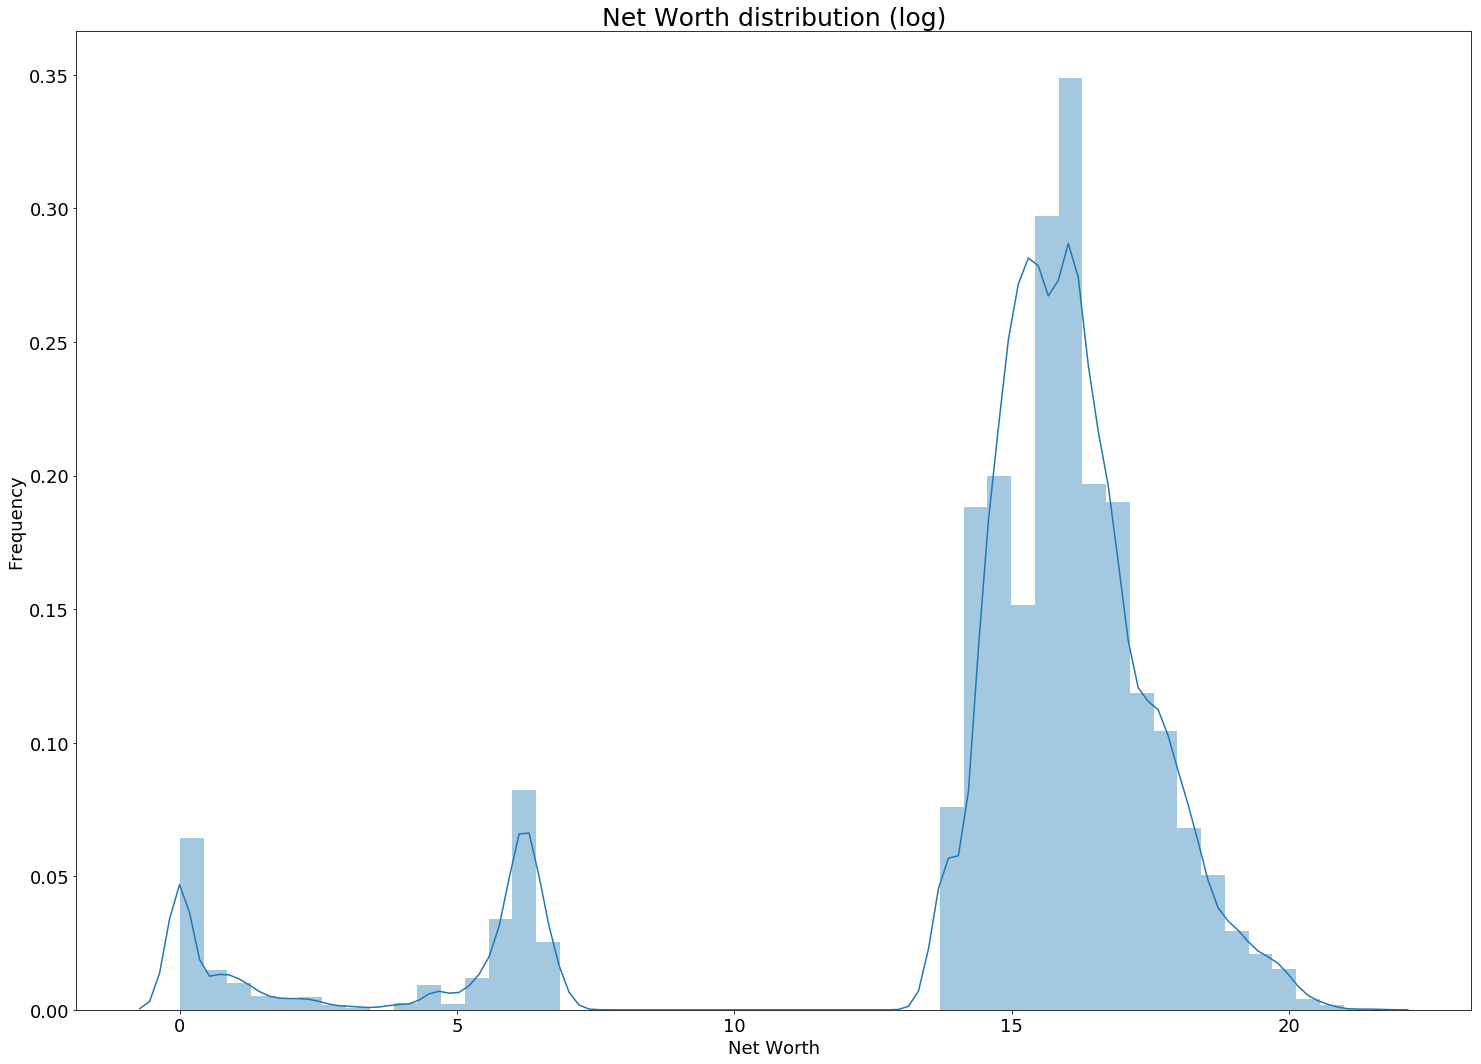

In [13]:
plt.figure(figsize=(25,18))
sns.distplot(np.log(df_big.Net_Worth.replace(0, 00000.1)))
plt.title('Net Worth distribution (log)', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Net Worth", fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

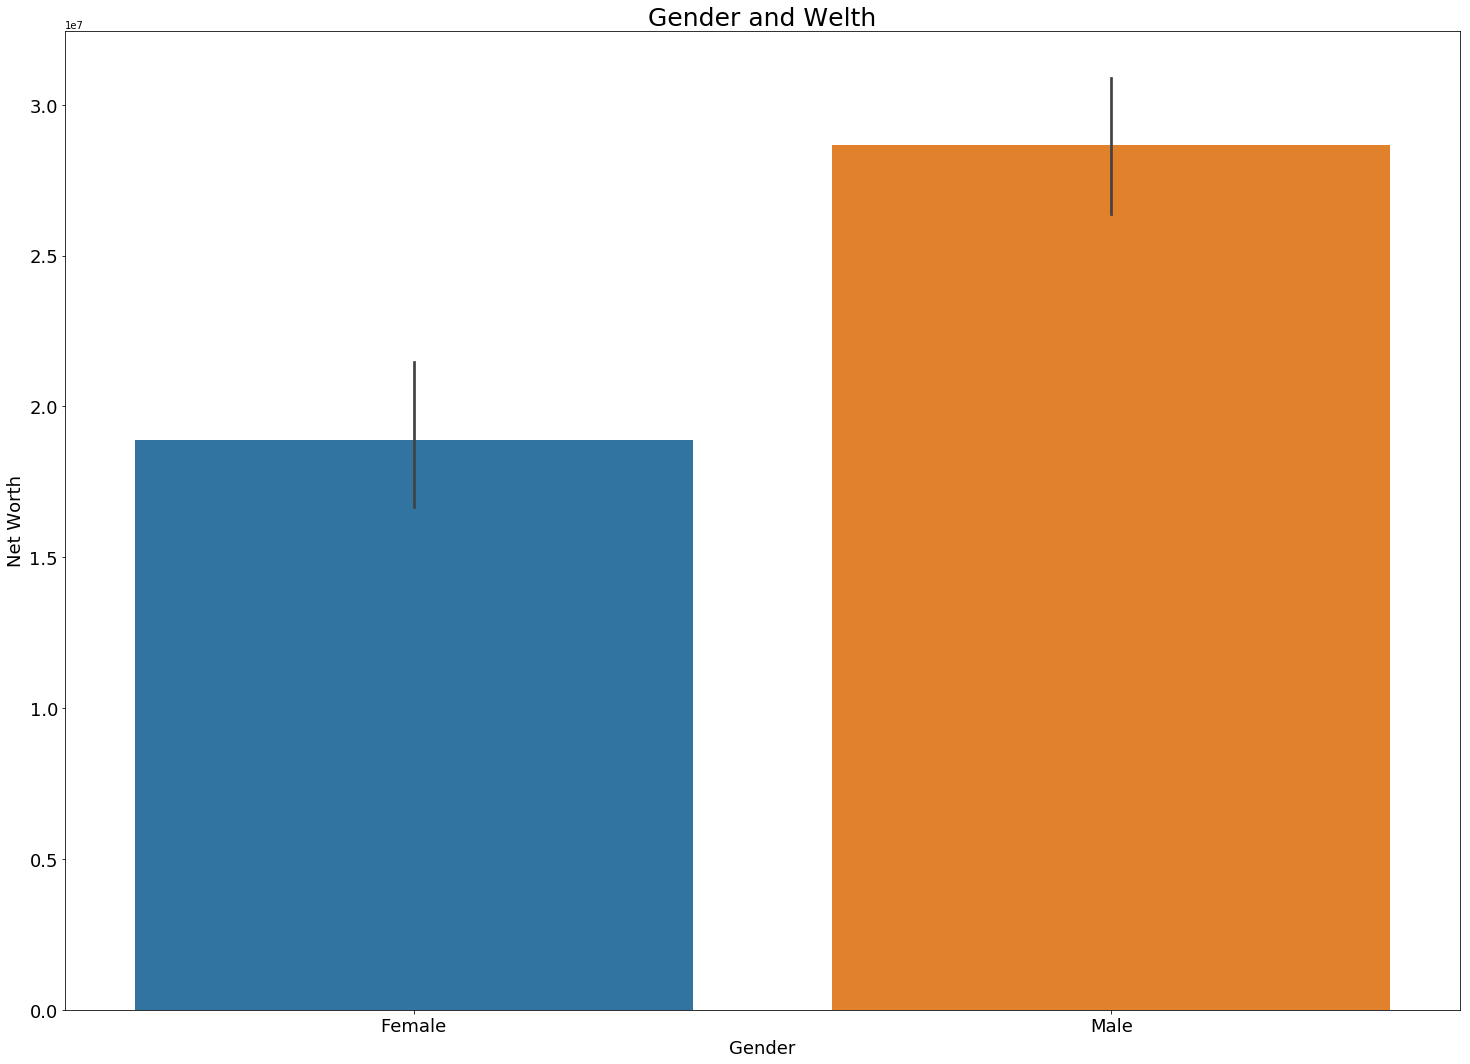

In [11]:
plt.figure(figsize=(25,18))
sns.barplot(x="Gender", y="Net_Worth", data=df_big)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Gender", fontsize=18)
plt.ylabel('Net Worth', fontsize=18)
plt.title('Gender and Welth', fontsize=25)
plt.show()

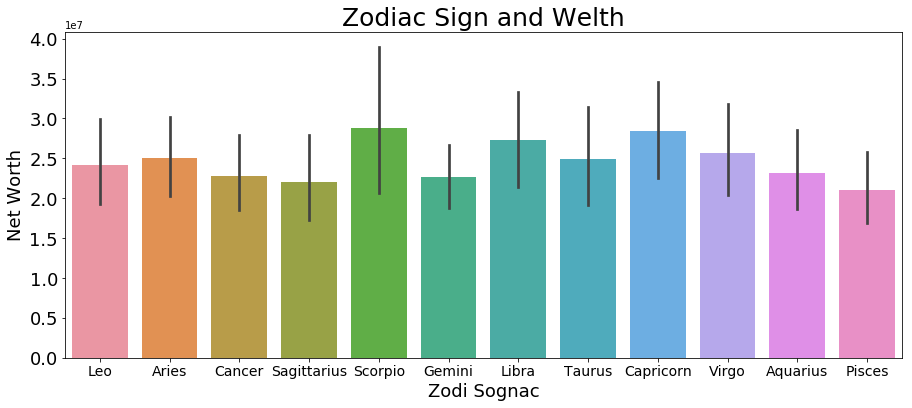

In [14]:
plt.figure(figsize=(15,6))
sns.barplot(x="Zodiac_Sign", y="Net_Worth", data=df_big)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
plt.xlabel("Zodi Sognac", fontsize=18)
plt.ylabel('Net Worth', fontsize=18)
plt.title('Zodiac Sign and Welth', fontsize=25)
plt.show()

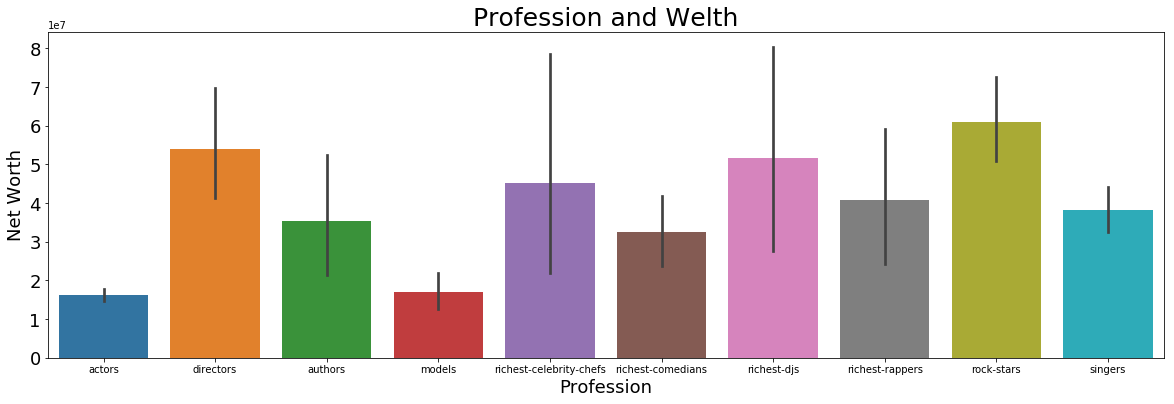

In [15]:
plt.figure(figsize=(20,6))
sns.barplot(x="Category", y="Net_Worth", data=df_big)

plt.xticks(fontsize=10)
plt.yticks(fontsize=18)
plt.xlabel("Profession", fontsize=18)
plt.ylabel('Net Worth', fontsize=18)

plt.title('Profession and Welth', fontsize=25)
plt.show()

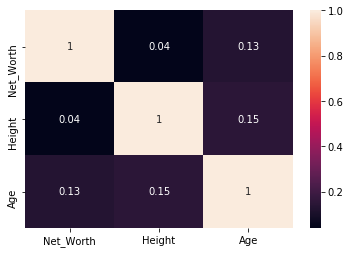

In [16]:
sns.heatmap(df_big.corr().abs().round(2), annot=True)
plt.show()

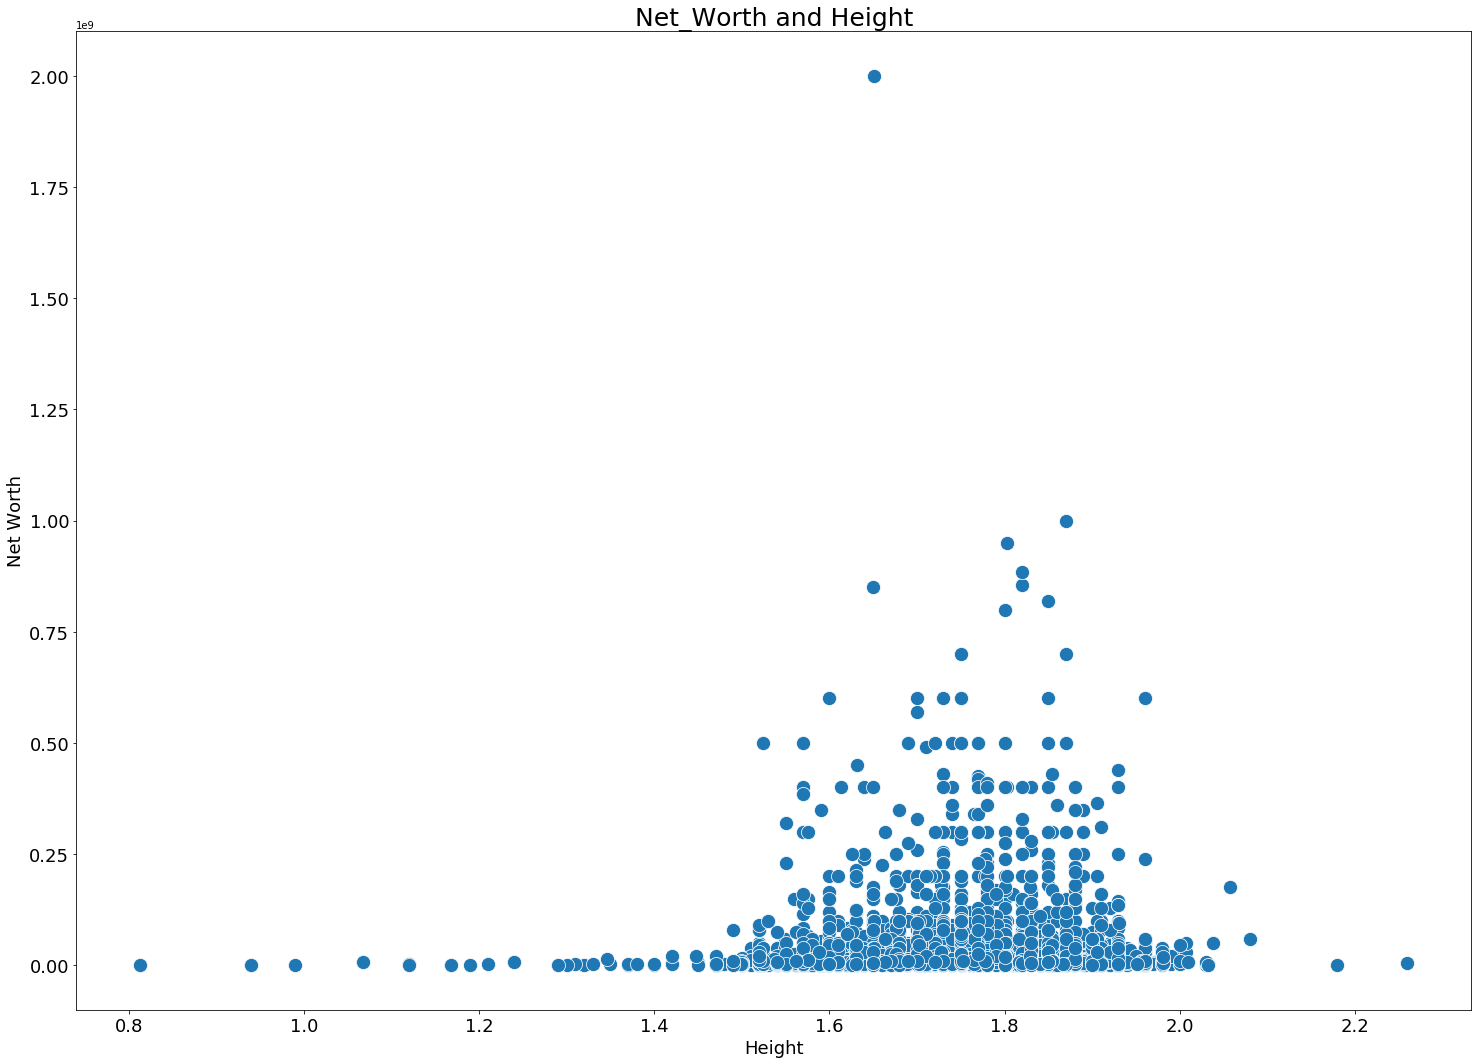

In [17]:
plt.figure(figsize=(25,18))
sns.scatterplot(x='Height', y='Net_Worth', data=df_big, s=200)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Height", fontsize=18)
plt.ylabel('Net Worth', fontsize=18)

plt.title('Net_Worth and Height', fontsize=25)
plt.show()

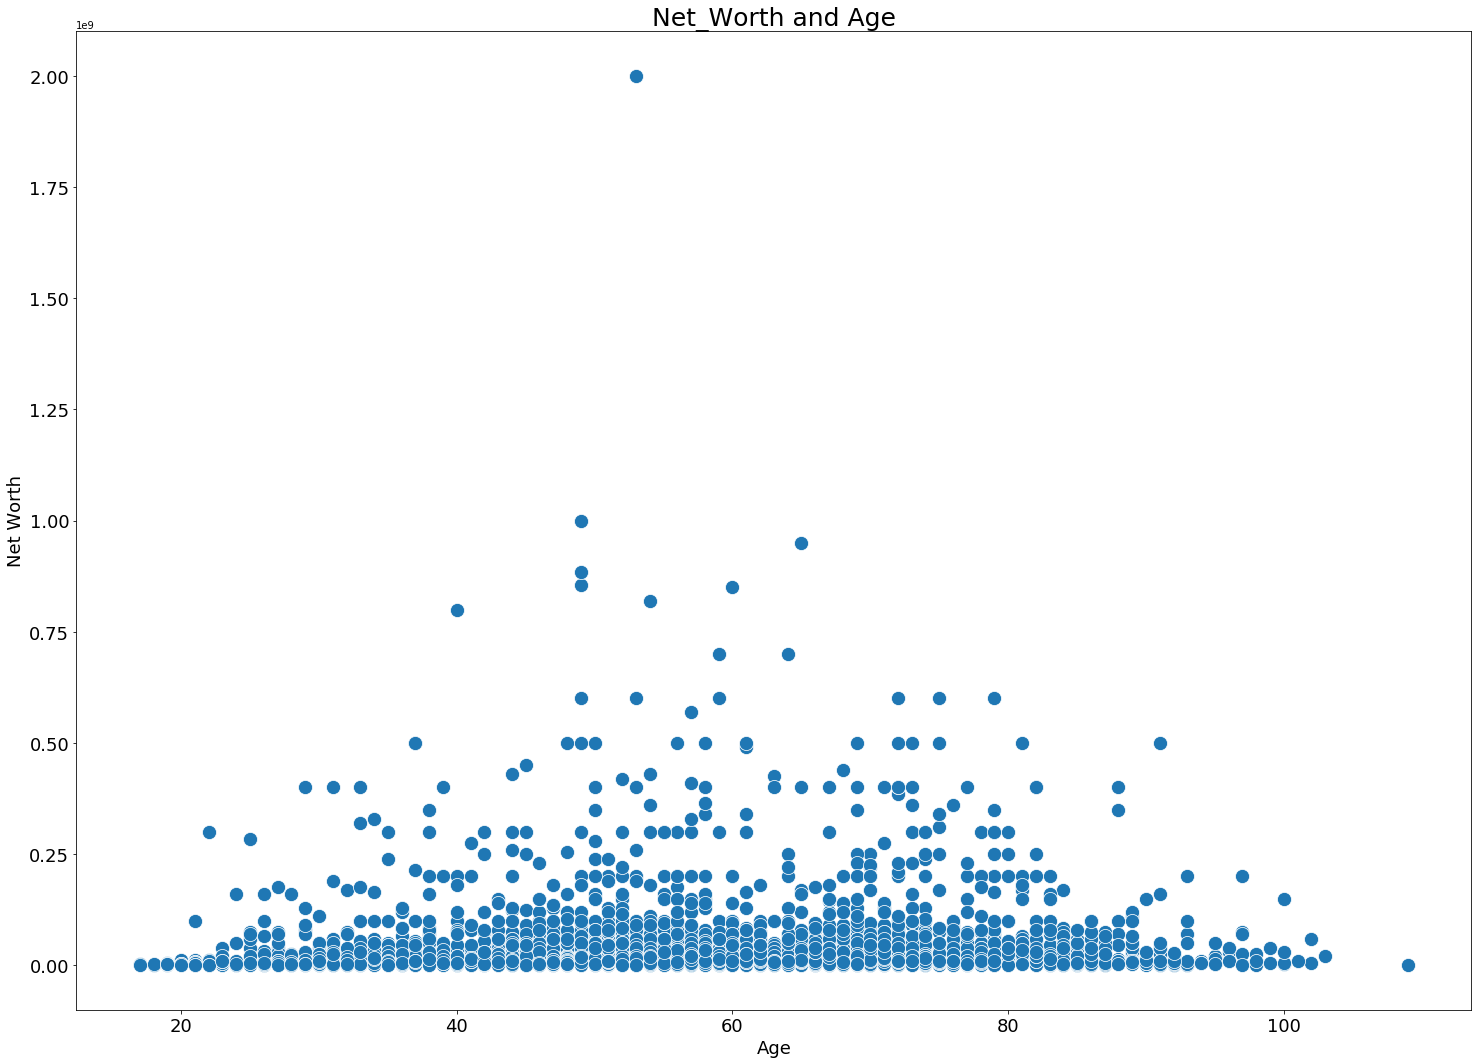

In [18]:
plt.figure(figsize=(25,18))
sns.scatterplot(x='Age', y='Net_Worth', data=df_big, s=200)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Age", fontsize=18)
plt.ylabel('Net Worth', fontsize=18)

plt.title('Net_Worth and Age', fontsize=25)
plt.show()

In [19]:
df_big.sort_values('Age', ascending=False).head(10)

,Name_Surname,Net_Worth,Date_of_Birth,Gender,Height,Profession,Nationality,Category,Age,Alive,Zodiac_Sign
1713,luise_rainer,1.0,Jan 12 1910,Female,1.6300,Actor,Germany,actors,109.0,Jan 12 1910,Capricorn
4277,olivia_de_havilland,20000000.0,Jul 1 1916,Female,1.6000,Actor,United Kingdom,actors,103.0,Jul 1 1916,Cancer
2049,kirk_douglas,60000000.0,Dec 9 1916,Male,1.7500,"Actor, Film Producer, Author, Film director, B...",United States of America,actors,102.0,Dec 9 1916,Sagittarius
2749,george_gaynes,5000000.0,May 16 1917,Male,1.8800,"Actor, Singer",United States of America,actors,102.0,May 16 1917,Taurus
4211,june_foray,10000000.0,Sep 18 1917,Female,1.4986,"Actor, Voice Actor",United States of America,actors,101.0,Sep 18 1917,Virgo
2227,gloria_stuart,5000000.0,Jul 4 1910,Female,1.6500,"Actor, Artist, Painter, Printmaker, Activist, ...",United States of America,actors,100.0,Jul 4 1910,Cancer
8568,george_burns,30000000.0,Jan 20 1896,Male,1.7000,"Comedian, Actor, Television Producer, Radio pe...",United States of America,richest-comedians,100.0,Jan 20 1896,Aquarius
1849,ellen_dow,2000000.0,Nov 16 1918,Female,1.4900,"Teacher, Actor, Choreographer",United States of America,actors,100.0,Nov 16 1918,Scorpio
8460,bob_hope,150000000.0,May 29 1903,Male,1.7900,"Comedian, Golfer, Actor, Film Producer, Author...",United States of America,richest-comedians,100.0,May 29 1903,Gemini
5062,alan_young,5000000.0,Nov 19 1919,Male,1.7800,"Actor, Voice Actor",United Kingdom,actors,99.0,Nov 19 1919,Scorpio


# Regression

In [28]:
df_small.isnull().values.any()

False

In [29]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309 entries, 2 to 12780
Data columns (total 12 columns):
Name_Surname     309 non-null object
Net_Worth        309 non-null float64
Date_of_Birth    309 non-null object
Gender           309 non-null object
Height           309 non-null float64
Profession       309 non-null object
Nationality      309 non-null object
Salary           309 non-null float64
Category         309 non-null object
Age              309 non-null float64
Alive            309 non-null object
Zodiac_Sign      309 non-null object
dtypes: float64(4), object(8)
memory usage: 31.4+ KB


In [30]:
df_small.describe()

,Net_Worth,Height,Salary,Age
count,3.090000e+02,309.000000,3.090000e+02,309.000000
mean,5.817799e+07,1.748381,9.072566e+06,49.724919
std,1.064088e+08,0.104521,2.662176e+07,12.428186
min,1.000000e+00,1.346000,1.000000e+00,20.000000
25%,1.000000e+07,1.680000,1.000000e+05,41.000000
50%,2.000000e+07,1.753000,2.500000e+05,49.000000
75%,4.500000e+07,1.830000,5.000000e+06,57.000000
max,6.000000e+08,1.960000,3.000000e+08,95.000000


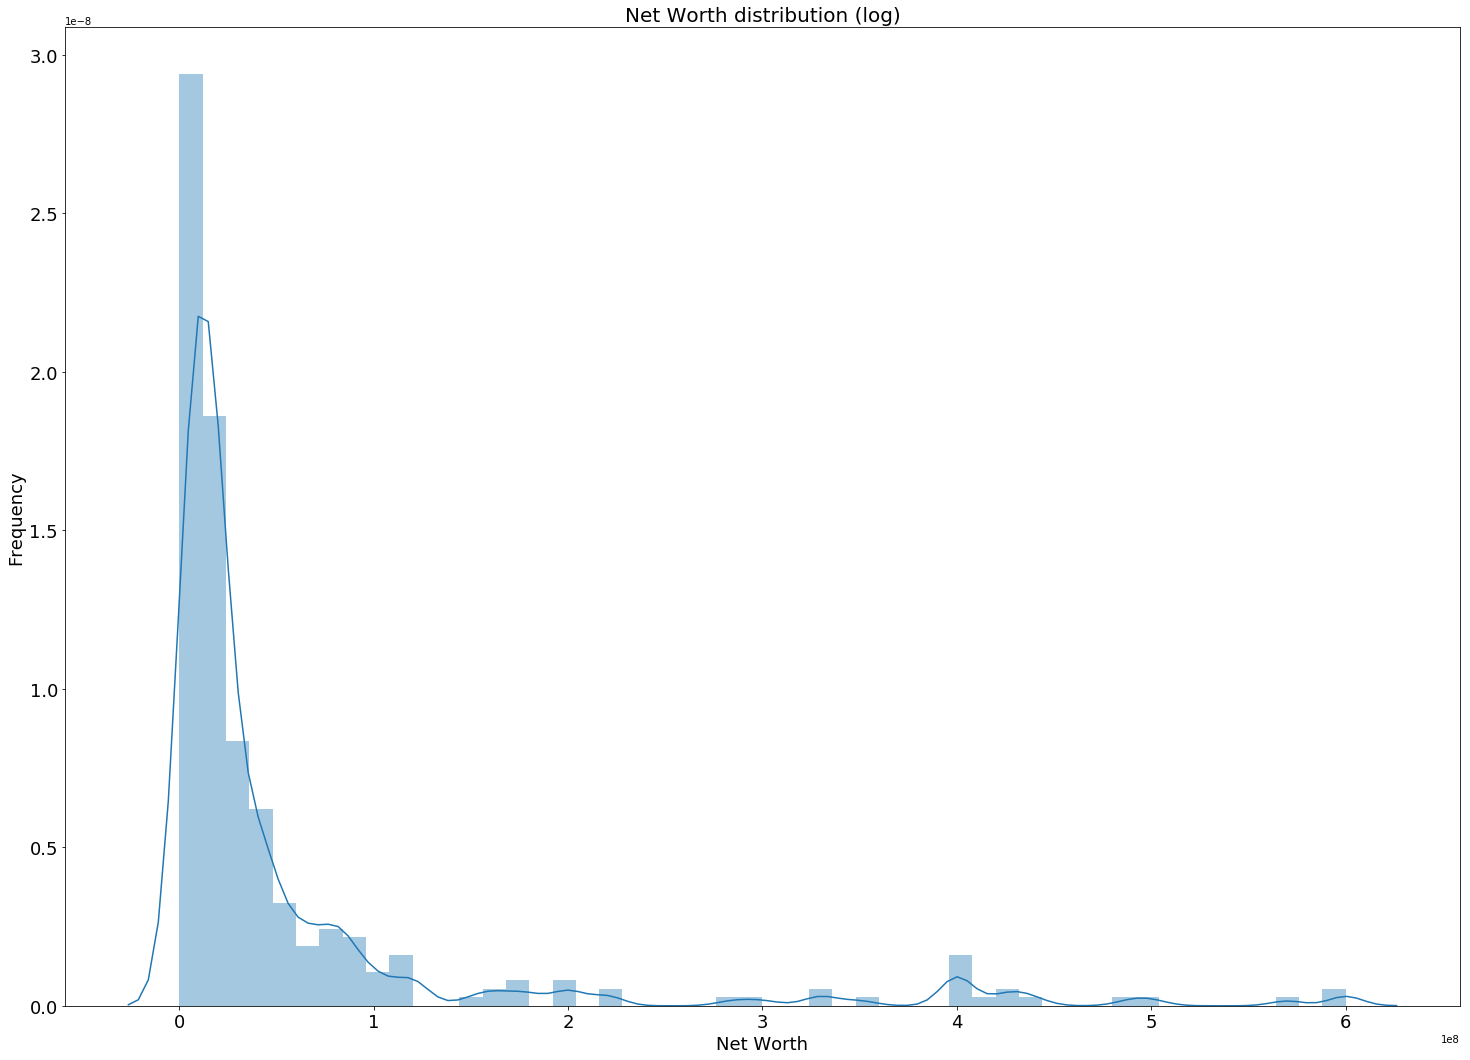

In [31]:
plt.figure(figsize=(25,18))
sns.distplot(df_small.Net_Worth.replace(0, 00000.1))
plt.title('Net Worth distribution (log)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Net Worth", fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

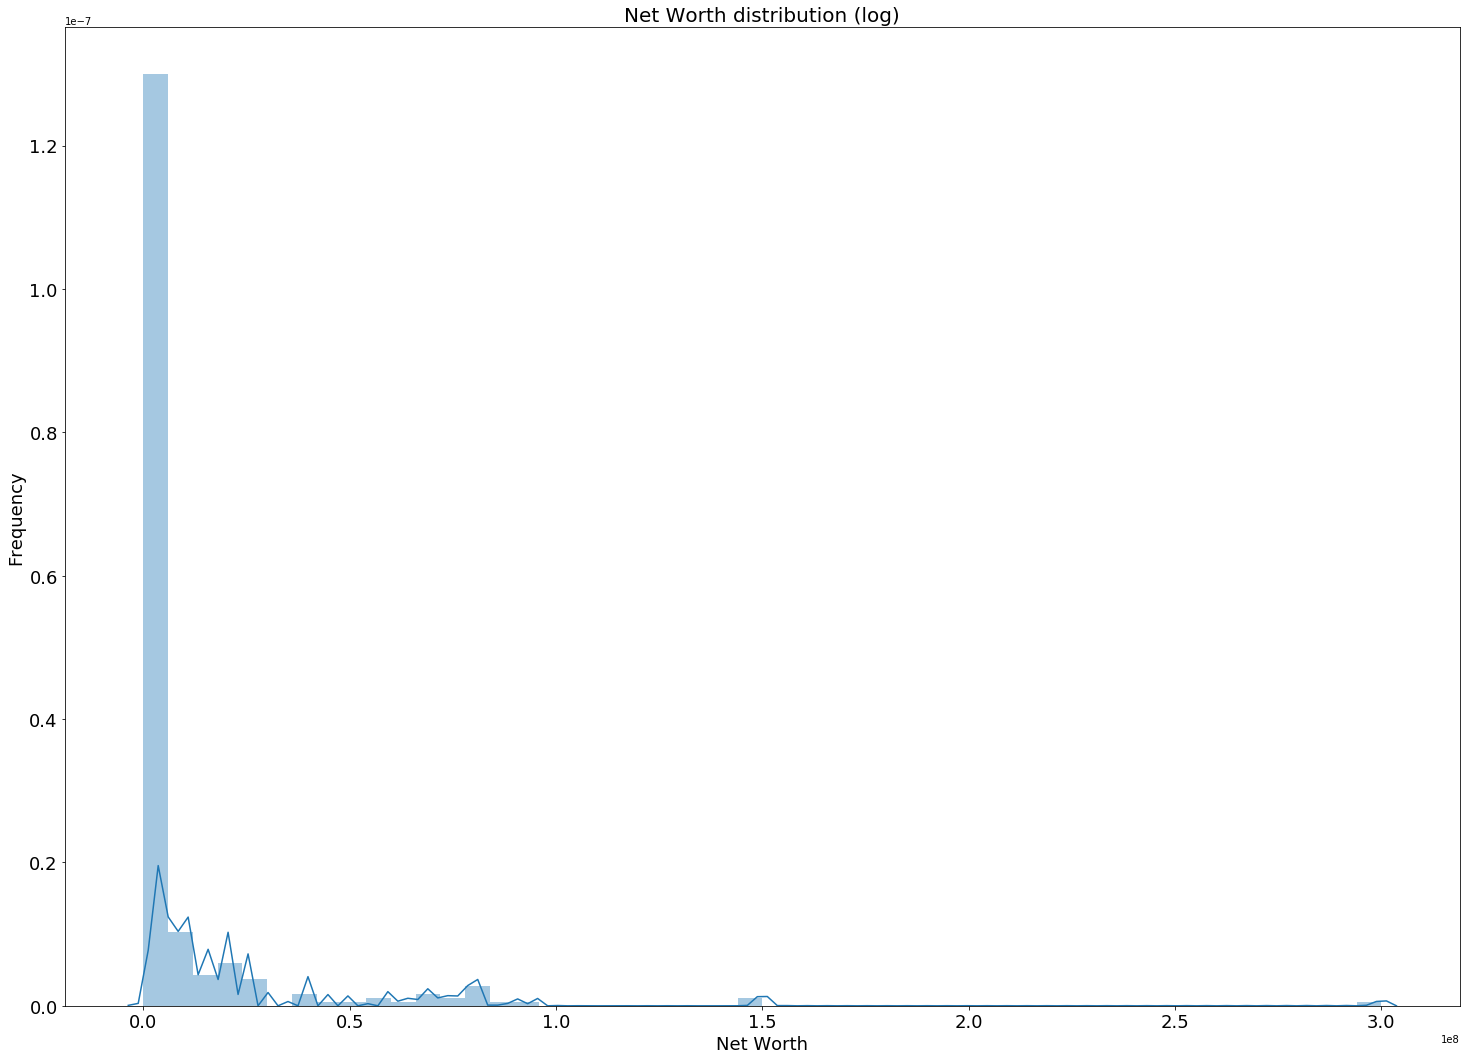

In [32]:
plt.figure(figsize=(25,18))
sns.distplot(df_small.Salary.replace(0, 00000.1))
plt.title('Net Worth distribution (log)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Net Worth", fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

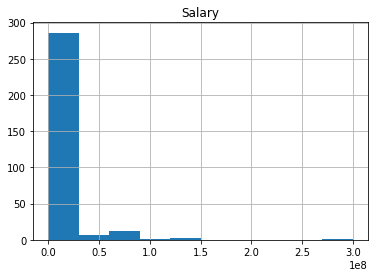

In [33]:
nw_hist=df_small.hist(column="Salary")

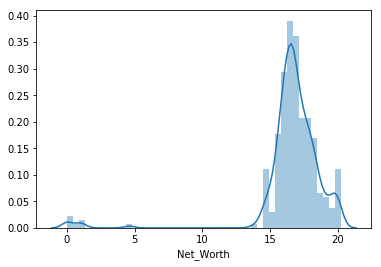

In [34]:
sns.distplot(np.log(df_small.Net_Worth.replace(0, 00000.1)))

In [35]:
data=df_small.dropna()

In [36]:
df_small['Salary']=df_small.Salary.apply(lambda x: np.log(x))
# np.log(data.Net_Worth.replace(0, 00000.1))


In [37]:
df_small[df_small.Salary == np.nan]

,Name_Surname,Net_Worth,Date_of_Birth,Gender,Height,Profession,Nationality,Salary,Category,Age,Alive,Zodiac_Sign


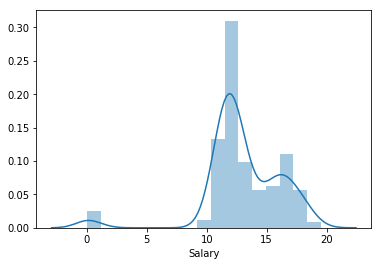

In [38]:
sns.distplot(df_small.Salary, hist=True)
plt.show()

In [39]:
df_small['Net_Worth']=df_small.Net_Worth.apply(lambda x: np.log(x))

In [40]:
data_numeric = df_small.select_dtypes(exclude=["object"])
data_object = df_small.select_dtypes(include=["object"])

In [41]:
for i in data_object.columns:
    j=data[i].value_counts()
    print(i,"\n",j,"\n","\n")
    print("--------------------")

Name_Surname 
 ty_burrell             1
adriana_lima           1
allison_janney         1
christina_aguilera     1
wendy_williams         1
david_muir             1
jim_norton             1
guillermo_rodriguez    1
kit_harington          1
katy_perry             1
steve_whitmire         1
shemar_moore           1
don_cheadle            1
mariska_hargitay       1
fred_rogers            1
ashton_kutcher         1
james_caviezel         1
dr_phil                1
justin_chambers        1
neil_patrick_harris    1
keith_urban            1
nancy_grace            1
blake_lively           1
michael_c_hall         1
dan_castellaneta       1
matt_bomer             1
padma_lakshmi          1
emilia_clarke          1
robin_meade            1
jason_lee              1
                      ..
clark_gregg            1
matthew_rhys           1
daniel_radcliffe       1
patrick_duffy          1
andre_braugher         1
pauley_perrette        1
shane_west             1
ryan_seacrest          1
kevin_dill

In [42]:
df_small.corr()

,Net_Worth,Height,Salary,Age
Net_Worth,1.000000,0.069324,0.247923,0.074682
Height,0.069324,1.000000,0.071875,0.193753
Salary,0.247923,0.071875,1.000000,0.146372
Age,0.074682,0.193753,0.146372,1.000000


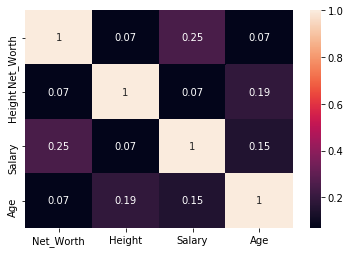

In [43]:
sns.heatmap(df_small.corr().abs().round(2), annot=True)

In [44]:
data_new=data_numeric.join(data_object,how='outer')

In [45]:
del data_new[ 'Name_Surname']

In [46]:
del data_new[ 'Date_of_Birth']

In [47]:
var=data_new.columns.tolist()
var

['Net_Worth',
 'Height',
 'Salary',
 'Age',
 'Gender',
 'Profession',
 'Nationality',
 'Category',
 'Alive',
 'Zodiac_Sign']

In [48]:
del var[0]

In [49]:
del var[5]

In [50]:
del var[7]

In [51]:
formula="+".join(var)
formula='Net_Worth~'+formula
formula

'Net_Worth~Height+Salary+Age+Gender+Profession+Category+Alive'

In [52]:
model_ols1=ols(formula=formula, data=data_new)

In [53]:
results=model_ols1.fit()
results.summary()

C:\Users\Ohanyan\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1549: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\Ohanyan\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1550: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
C:\Users\Ohanyan\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
C:\Users\Ohanyan\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Net_Worth   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Mon, 19 Aug 2019   Prob (F-statistic):                nan
Time:                        13:08:05   Log-Likelihood:                 8575.5
No. Observations:                 309   AIC:                        -1.653e+04
Df Residuals:                       0   BIC:                        -1.538e+04
Df Model:                         308                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================================================================================
                                                                                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                                       5.9306        inf          0        nan         nan         nan
Gender[T.Male]                                                                                                                                                 -0.5193        inf         -0        nan         nan         nan
Profession[T.Actor]                                                                                                                                            -0.7738        inf         -0        nan         nan         nan
Profession[T.Actor, Author, Voice Actor, Neuroscientist]                                                                                                        0.3960        inf          0        nan         nan         nan
Profession[T.Actor, Ballet Dancer, Photographer]                                                                                                               -0.1135        inf         -0        nan         nan         nan
Profession[T.Actor, Businessperson, Voice Actor]                                                                                                               -0.4698        inf         -0        nan         nan         nan
Profession[T.Actor, Comedian]                                                                                                                                  -0.6656        inf         -0        nan         nan         nan
Profession[T.Actor, Comedian, Businessperson, Voice Actor]                                                                                                      0.2351        inf          0        nan         nan         nan
Profession[T.Actor, Comedian, Entertainer, Film Producer, Screenwriter, Radio personality, Author, TV Personality, Television producer]                         0.1860        inf          0        nan         nan         nan
Profession[T.Actor, Comedian, Model, Television producer, Screenwriter]                                                                                         0.0103        inf          0        nan         nan         nan
Profession[T.Actor, Comedian, Musician, Voice Actor, Screenwriter, Television producer, Television Director, Singer, Author, Writer]                            0.1176     

In [54]:
residuals=results.resid
residuals.head(10)

2     -4.192202e-13
15     1.634248e-13
54     2.842171e-13
106    3.339551e-13
117    2.593481e-13
160    2.433609e-13
186    1.723066e-13
213    2.398082e-13
221    1.634248e-13
253    3.073097e-13
dtype: float64

In [55]:
pred_values=results.predict()
true_values=data_new['Net_Worth']
resid=true_values-pred_values

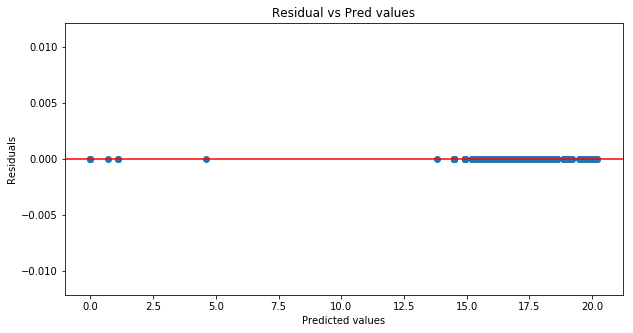

In [56]:
plt.figure(figsize=(10,5))
plt.scatter(pred_values,residuals)
plt.axhline(y=0, c="red")
plt.title("Residual vs Pred values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

In [57]:
sms.diagnostic.het_breuschpagan(residuals,model_ols1.exog)

(309.0, 1.0, 0.0, nan)

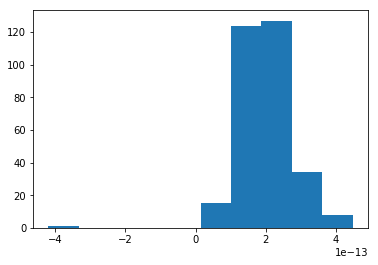

In [58]:
plt.hist(residuals)
plt.show()

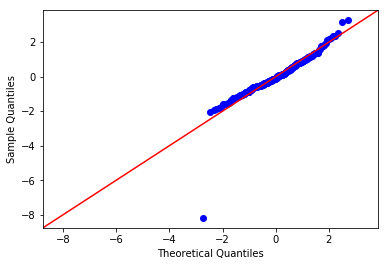

In [59]:
qqplot(residuals,fit=True, line='45')
plt.show()

In [60]:
stat,p = shapiro(residuals)
print(stat,p)

0.8957311511039734 9.876889345457329e-14
